# Step Forward Cross Validation for Bioactivity Prediction

In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv("../benchmark/data/results/target_CHEMBL279-1.IC50.csv")

In [5]:
df

,Unnamed: 0.1,Unnamed: 0,assay_chembl_id,compound_chembl_id,canonical_smiles,pchembl_value,standardized_smiles,LogD,LogP,MCE18,...,UnsortedStepForward_Fold_6_AtomPairsFP_mlp_regressor_factory,UnsortedStepForward_Fold_7_AtomPairsFP_rf_regressor_factory,UnsortedStepForward_Fold_7_AtomPairsFP_xgb_regressor_factory,UnsortedStepForward_Fold_7_AtomPairsFP_mlp_regressor_factory,UnsortedStepForward_Fold_8_AtomPairsFP_rf_regressor_factory,UnsortedStepForward_Fold_8_AtomPairsFP_xgb_regressor_factory,UnsortedStepForward_Fold_8_AtomPairsFP_mlp_regressor_factory,UnsortedStepForward_Fold_9_AtomPairsFP_rf_regressor_factory,UnsortedStepForward_Fold_9_AtomPairsFP_xgb_regressor_factory,UnsortedStepForward_Fold_9_AtomPairsFP_mlp_regressor_factory
0,0,0,CHEMBL828488,CHEMBL364115,CN(c1ccc(NC(=O)N2CCN(CCCN3CCOCC3)CC2)cc1)c1ccn...,5.35,CN(c1ccc(NC(=O)N2CCN(CCCN3CCOCC3)CC2)cc1)c1ccn...,2.265543,3.4045,152.264646,...,5.230483,5.8600,5.352528,5.213142,5.6780,5.291760,5.458062,6.003200,5.348607,5.552361
1,1,1,CHEMBL828488,CHEMBL189291,CN(c1ccc(NC(=O)Nc2cc(C(F)(F)F)ccc2F)cc1)c1ccnc...,7.46,CN(c1ccc(NC(=O)Nc2cc(C(F)(F)F)ccc2F)cc1)c1ccnc...,4.795027,6.3346,116.000000,...,7.448712,8.0032,7.493364,7.514852,7.7632,7.668865,7.696910,7.797200,7.647656,7.722080
2,2,2,CHEMBL828488,CHEMBL189199,CN(c1ccc(N/C(S)=N/c2ccccc2)cc1)c1ccnc(Nc2cccc(...,6.93,CN(c1ccc(N/C(S)=N/c2ccccc2)cc1)c1ccnc(Nc2cccc(...,4.844274,5.5621,96.000000,...,2.903171,6.8388,6.449015,2.532960,6.7816,6.908808,6.971552,6.852000,6.907992,7.034041
3,3,3,CHEMBL828488,CHEMBL189354,CN(c1ccc(NC(=O)Nc2cc(C(F)(F)F)ccc2F)cc1)c1ccnc...,9.00,CN(c1ccc(NC(=O)Nc2cc(C(F)(F)F)ccc2F)cc1)c1ccnc...,4.231542,5.4374,116.000000,...,8.902024,8.1672,8.958656,8.940166,8.5544,8.898095,9.057058,8.582400,9.030476,9.120240
4,4,4,CHEMBL828488,CHEMBL425718,CCNC(=O)Nc1ccc(N(C)c2ccnc(Nc3cccc(CS(C)(=O)=O)...,7.77,CCNC(=O)Nc1ccc(N(C)c2ccnc(Nc3cccc(CS(C)(=O)=O)...,2.273918,3.6741,60.000000,...,7.709716,7.4392,7.460603,7.794235,7.5864,7.636207,7.871076,7.610000,7.335064,7.883688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1654,1654,1654,CHEMBL5047431,CHEMBL5074310,CCc1cc(O)c(F)cc1-c1cc(N[C@H](C)CO)c2nc(N)ncc2c1,5.90,CCc1cc(O)c(F)cc1-c1cc(N[C@H](C)CO)c2nc(N)ncc2c1,1.901672,3.0788,76.000000,...,5.652632,6.1064,6.082291,5.925793,6.1910,6.102009,5.916588,6.076143,6.152394,5.938189
1655,1655,1655,CHEMBL5047431,CHEMBL5084542,CCc1cc(O)c(F)cc1-c1cc(NC2CCN(C(C)=O)CC2)c2nc(N...,6.20,CCc1cc(O)c(F)cc1-c1cc(NC2CCN(C(C)=O)CC2)c2nc(N...,2.249914,3.7089,101.744017,...,6.141478,6.1900,6.317245,6.175325,6.4020,6.201225,6.402258,6.350800,6.031687,6.496930
1656,1656,1656,CHEMBL5047431,CHEMBL5075673,CCc1cc(O)c(F)cc1-c1cc(N[C@@H]2C[C@H]3CC[C@@H](...,6.00,CCc1cc(O)c(F)cc1-c1cc(N[C@@H]2C[C@H]3CC[C@@H](...,2.124121,3.9810,171.056250,...,5.919666,6.0956,6.036121,5.934524,6.0344,6.013622,6.058981,6.462000,6.243930,6.576186
1657,1657,1657,CHEMBL5047431,CHEMBL5089877,CCc1c(-c2cc(OC)c3nc(N)ncc3c2)ccc(O)c1F,5.60,CCc1c(-c2cc(OC)c3nc(N)ncc3c2)ccc(O)c1F,2.775688,3.2947,54.000000,...,6.288083,5.9212,5.858094,5.731312,5.7764,5.653511,5.759267,5.876400,5.879129,5.615131


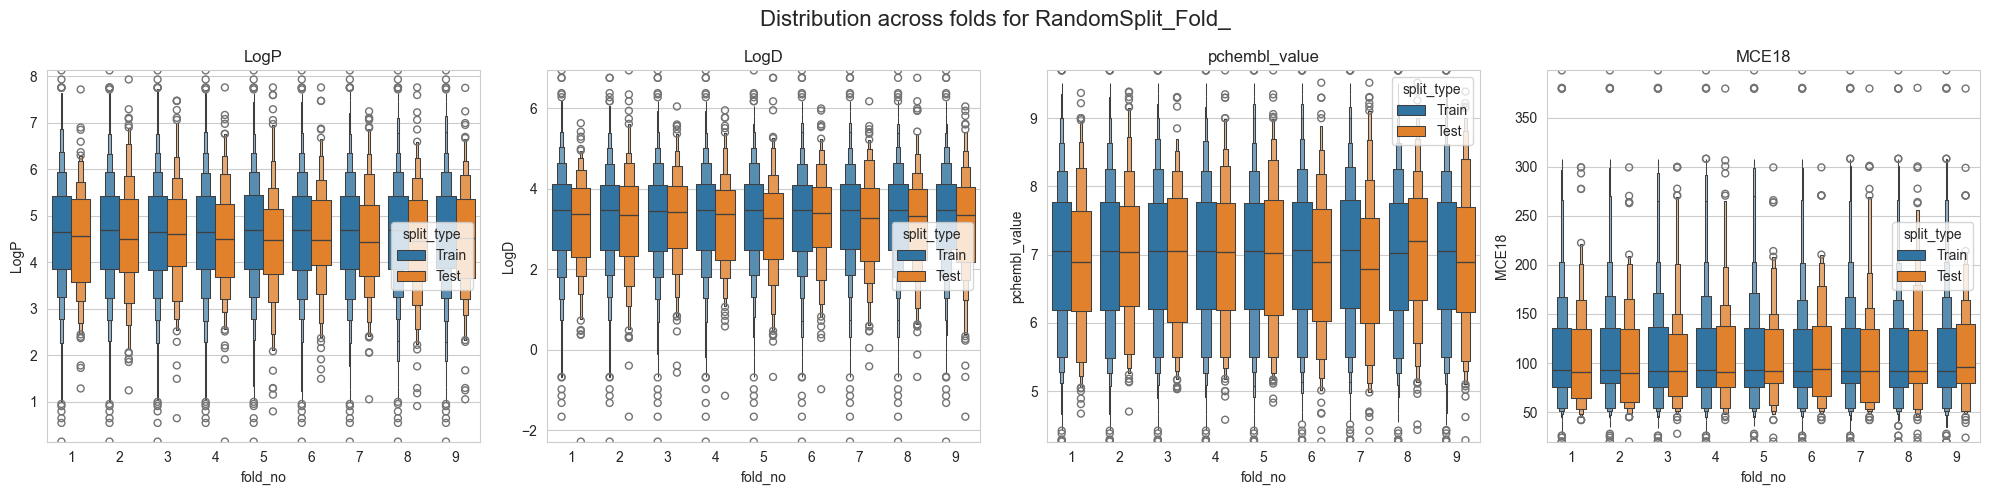

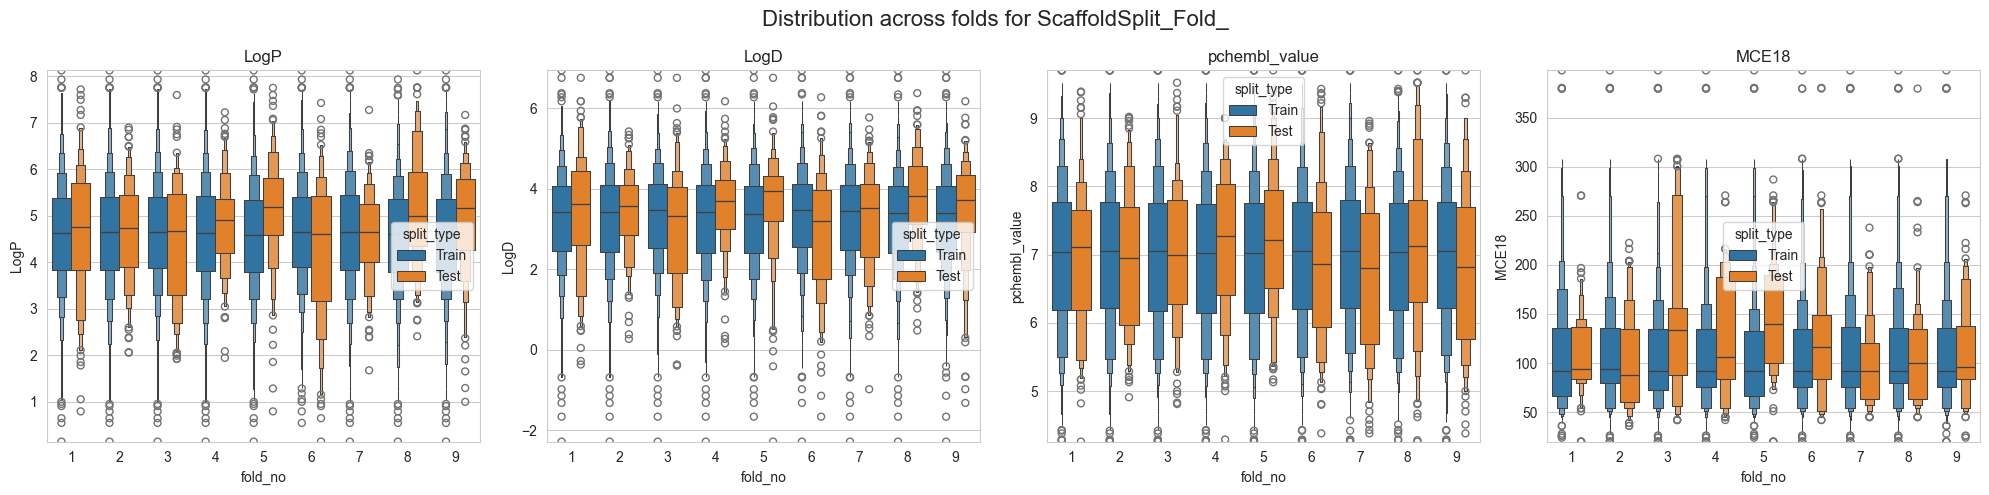

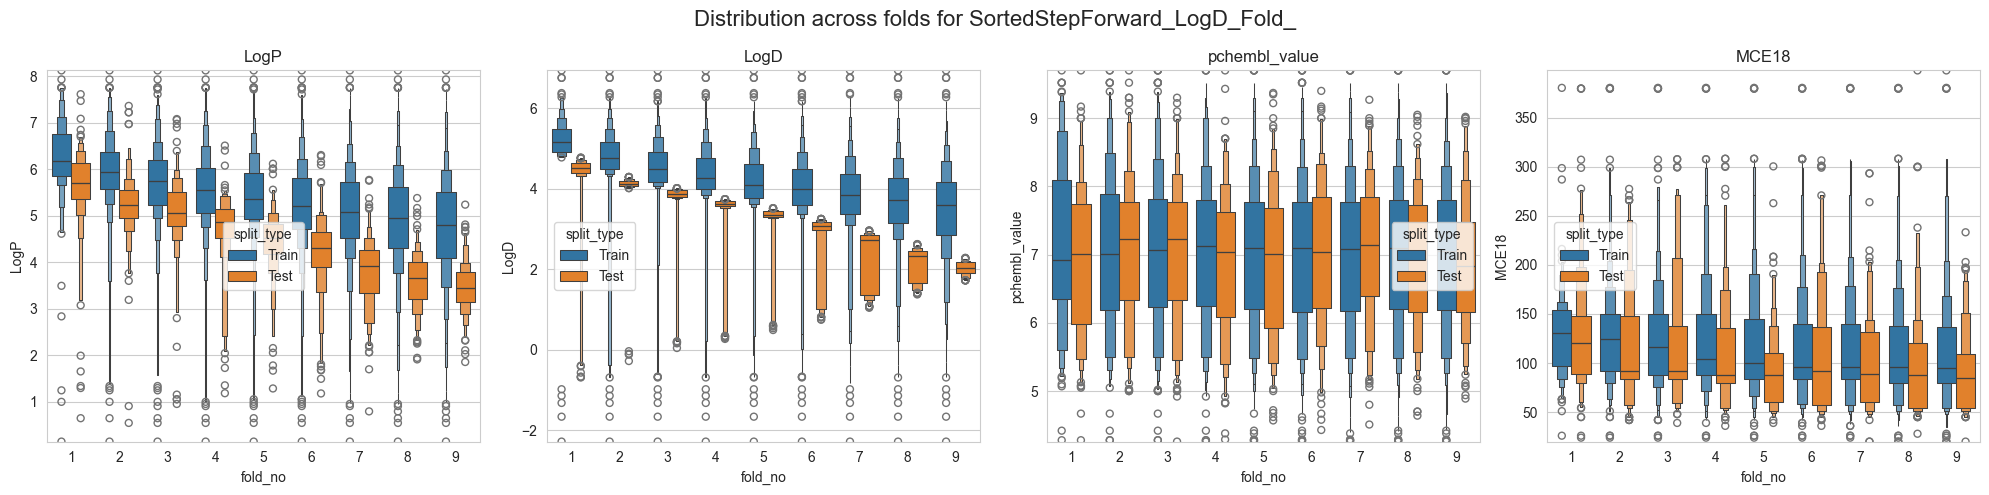

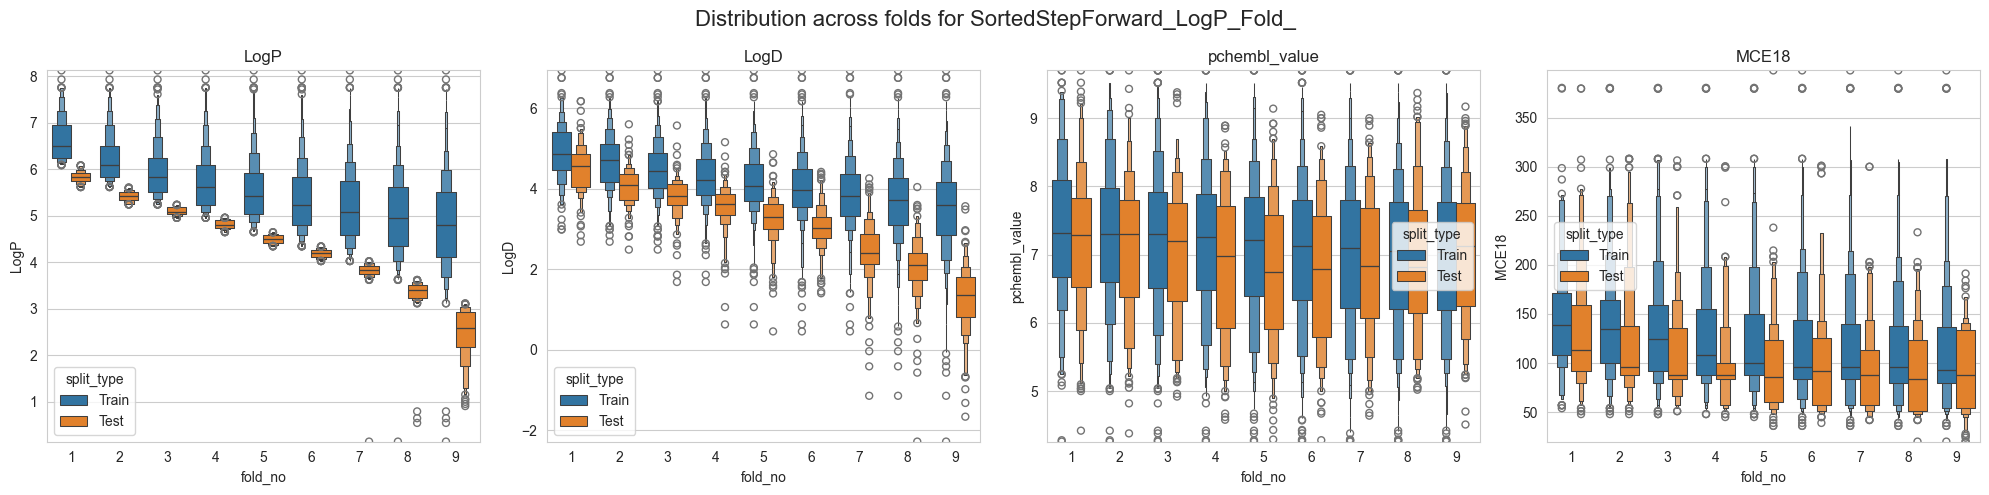

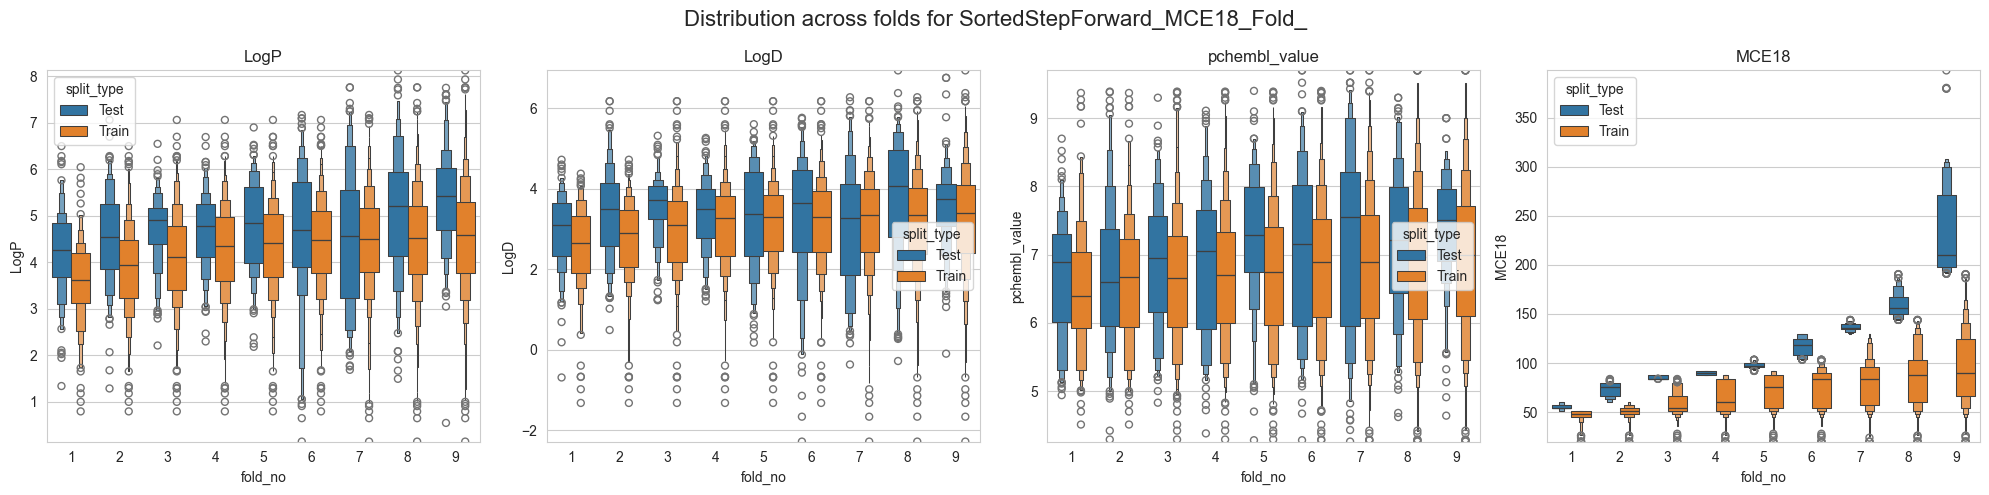

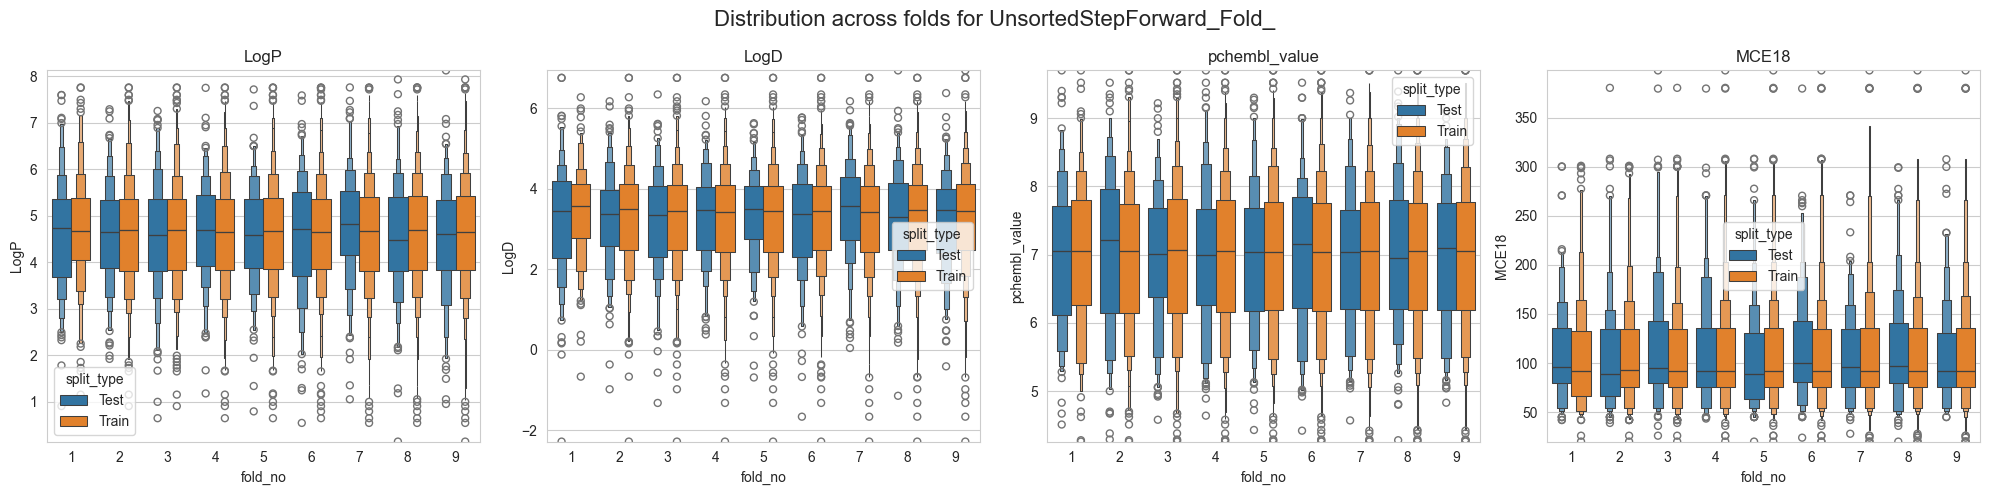

In [6]:
properties = ["LogP", "LogD", "pchembl_value", "MCE18"]
split_types = ['RandomSplit_Fold_', 'ScaffoldSplit_Fold_', 'SortedStepForward_LogD_Fold_',
               'SortedStepForward_LogP_Fold_', 'SortedStepForward_MCE18_Fold_', 'UnsortedStepForward_Fold_']
# Ensure fold columns contain numeric fold numbers
for split_type in split_types:
    fold_cols = [f"{split_type}{i}" for i in range(1, 10)]
    df_long = df.melt(id_vars=properties, value_vars=fold_cols,
                      var_name="fold_no", value_name="split_type")
    df_long["fold_no"] = df_long["fold_no"].str.extract(r'_Fold_(\d+)').astype(int)

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle(f"Distribution across folds for {split_type}", fontsize=16)

    for i, prop in enumerate(properties):
        sns.boxenplot(x="fold_no", y=prop, data=df_long, ax=axes[i], hue="split_type")
        axes[i].set_title(prop)
        axes[i].tick_params(axis='x')
        axes[i].set_ylim(df[prop].min(), df[prop].max())  # Scale each subplot independently

    plt.tight_layout()
    plt.show()


In [7]:
def plot_dissimilar_compounds_using_Tc(df, threshold=0.55, split_types=split_types,
                                       fp_cols=["ECFP4", "AtomPairsFP", "RDKitFP"]):
    fig, axes = plt.subplots(1, len(fp_cols), figsize=(7 * len(fp_cols), 6), sharey=True)

    if len(fp_cols) == 1:
        axes = [axes]  # Ensure axes is always iterable

    for ax, fp_col in zip(axes, fp_cols):
        for split_prefix in split_types:
            Tc_cols = [col for col in df.columns if col.startswith(split_prefix) and col.endswith(f"_{fp_col}_Tc")]
            batch_counts = [(df[Tc_col] < threshold).sum() for Tc_col in Tc_cols]

            ax.plot(range(1, len(batch_counts) + 1), batch_counts, marker='o', label=split_prefix)

        ax.set_xlabel("Testing Batch", fontsize=12)
        ax.set_title(f"{fp_col}", fontsize=14)
        ax.legend(title="Split Types", fontsize=10)
        ax.grid(True)

    axes[0].set_ylabel("Number of Molecules", fontsize=12)  # Leftmost plot gets the ylabel

    plt.tight_layout()
    plt.show()

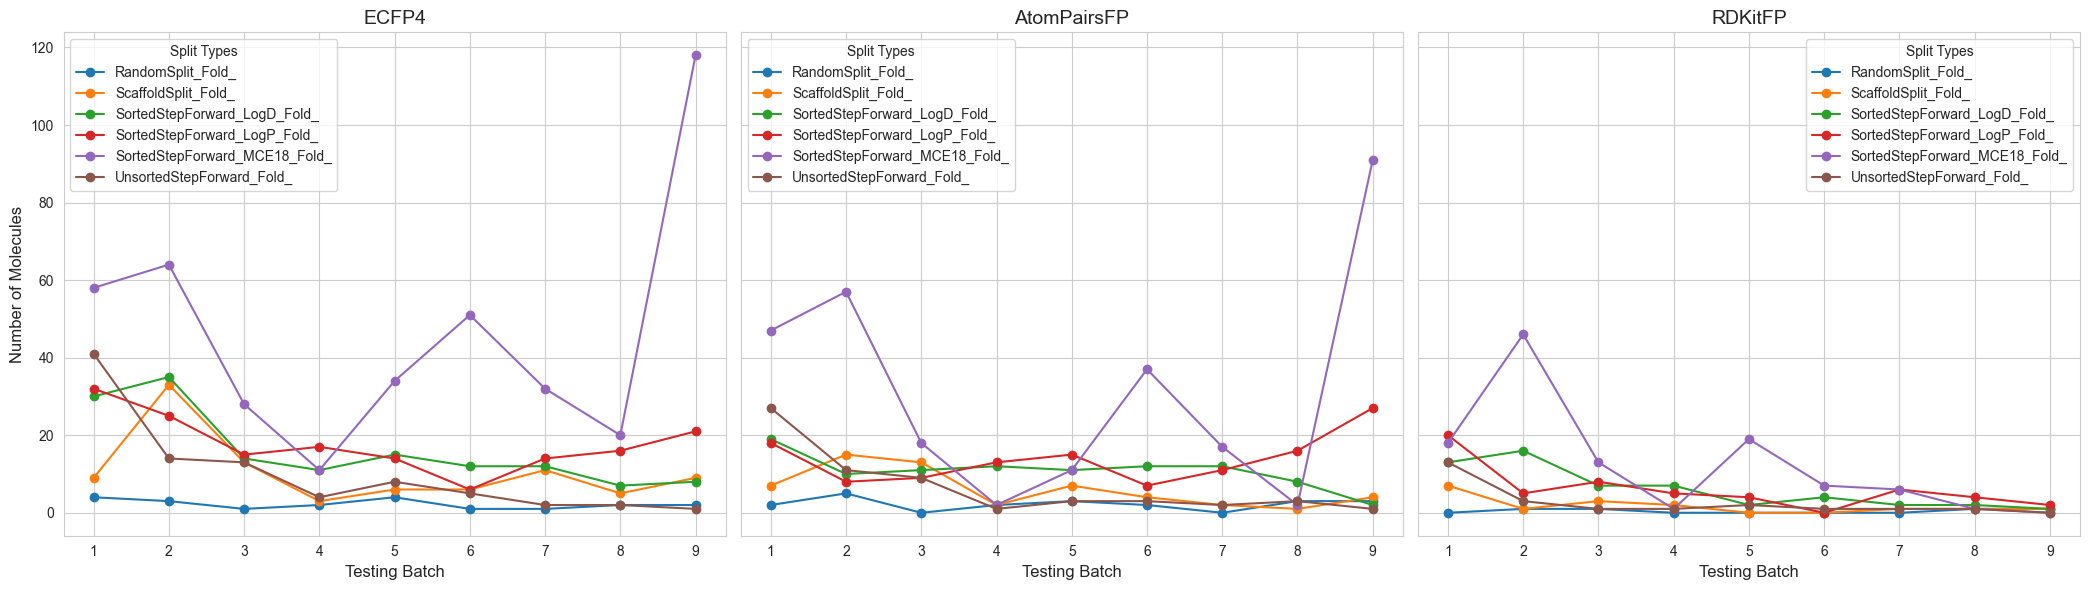

In [8]:
plot_dissimilar_compounds_using_Tc(df, threshold=0.55)

In [9]:
pred_cols = [col for col in df.columns if
             col.startswith(split_types[0]) and col.endswith(f"ECFP4_rf_regressor_factory")]

In [10]:
re.search(rf"", pred_cols[0])


<re.Match object; span=(0, 0), match=''>

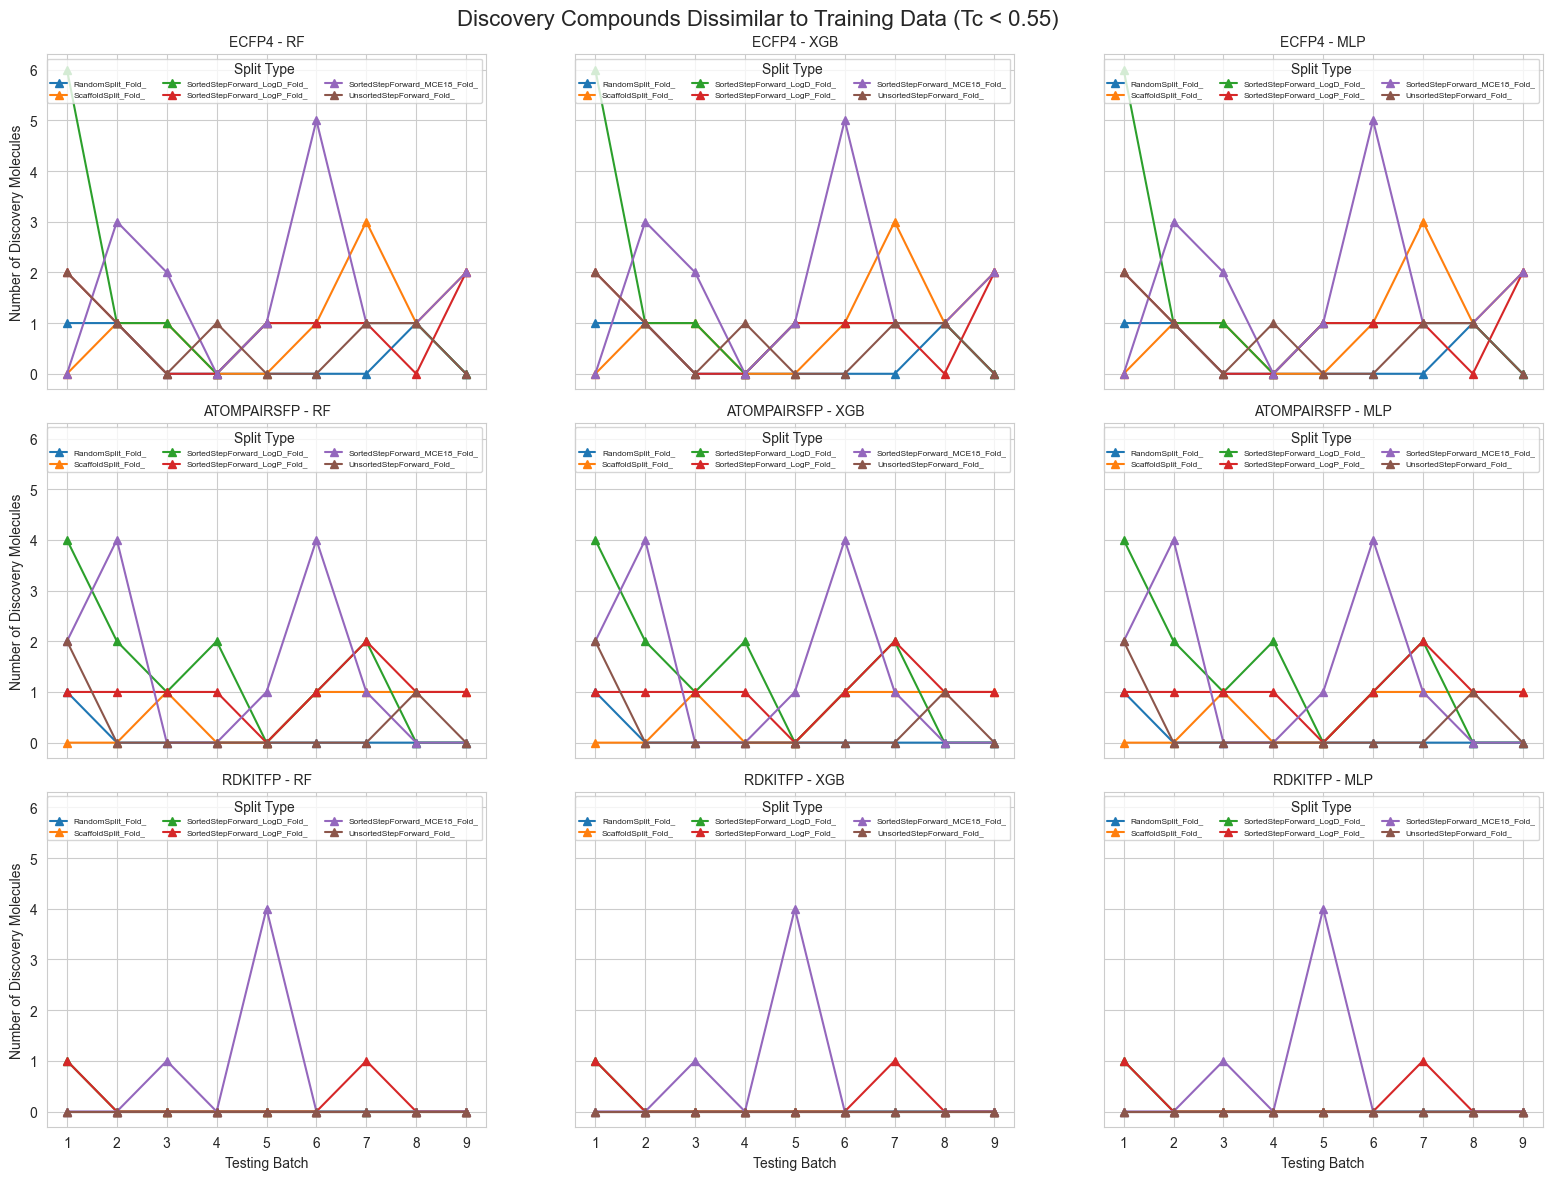

In [11]:
def plot_discovery_dissimilar_compounds_grid(
        df,
        condition="pchembl_value < 5.2",
        similarity_threshold=0.55,
        split_types=split_types,
        fp_cols=["ECFP4", "AtomPairsFP", "RDKitFP"],
        models=["rf", "xgb", "mlp"]
):
    fig, axes = plt.subplots(len(fp_cols), len(models), figsize=(16, 12), sharex=True, sharey=True)

    for i, fp_col in enumerate(fp_cols):
        for j, model in enumerate(models):
            ax = axes[i, j] if len(fp_cols) > 1 else axes[j]  # Handle axes for single row
            for split_prefix in split_types:
                pred_cols = [col for col in df.columns if
                             col.startswith(f"{split_prefix}") and col.endswith(f"_{fp_col}_{model}_regressor_factory")]
                batch_counts = []

                for pred_col in pred_cols:
                    match = re.search(r"Fold_(\d+)", pred_col)
                    if not match:
                        print(pred_col)
                        print("WTF")
                        continue
                    fold_number = match.group(1)

                    # Construct the corresponding similarity column name
                    similarity_col = f"{split_prefix}{fold_number}_{fp_col}_Tc"
                    if similarity_col not in df.columns:
                        print(f"[Missing] !! {similarity_col} !! [Missing]")
                        raise Exception()

                    # Filter test set compounds
                    split_col = pred_col.replace(f"_{fp_col}_{model}_regressor_factory", "")
                    test_indices = df.index[df[split_col] == "Test"]

                    # Extract true and predicted values
                    true_values = df.loc[test_indices, "pchembl_value"]
                    predicted_values = df.loc[test_indices, pred_col]

                    # Evaluate the condition dynamically
                    discovery_condition = df.loc[test_indices].eval(condition)

                    # Check Tanimoto similarity (Tc < threshold)
                    dissimilar_condition = df.loc[test_indices, similarity_col] < similarity_threshold
                    discovery_dissimilar = discovery_condition & dissimilar_condition

                    # Count discovery compounds dissimilar to training data
                    within_error = discovery_dissimilar.sum()
                    batch_counts.append(within_error)

                # Add the results for this split type to the plot
                ax.plot(
                    range(1, len(batch_counts) + 1),
                    batch_counts,
                    marker='^',
                    label=f"{split_prefix}"
                )

            # Customize each subplot
            ax.set_title(f"{fp_col.upper()} - {model.upper()}", fontsize=10)
            if j == 0:
                ax.set_ylabel("Number of Discovery Molecules", fontsize=10)
            if i == len(fp_cols) - 1:
                ax.set_xlabel("Testing Batch", fontsize=10)
            ax.legend(title="Split Type", fontsize=6, ncols=3, loc="upper right")
            ax.grid(True)

    fig.suptitle(f"Discovery Compounds Dissimilar to Training Data (Tc < {similarity_threshold})", fontsize=16)
    plt.tight_layout()
    plt.show()


plot_discovery_dissimilar_compounds_grid(df, condition="pchembl_value < 5.2", similarity_threshold=0.55)

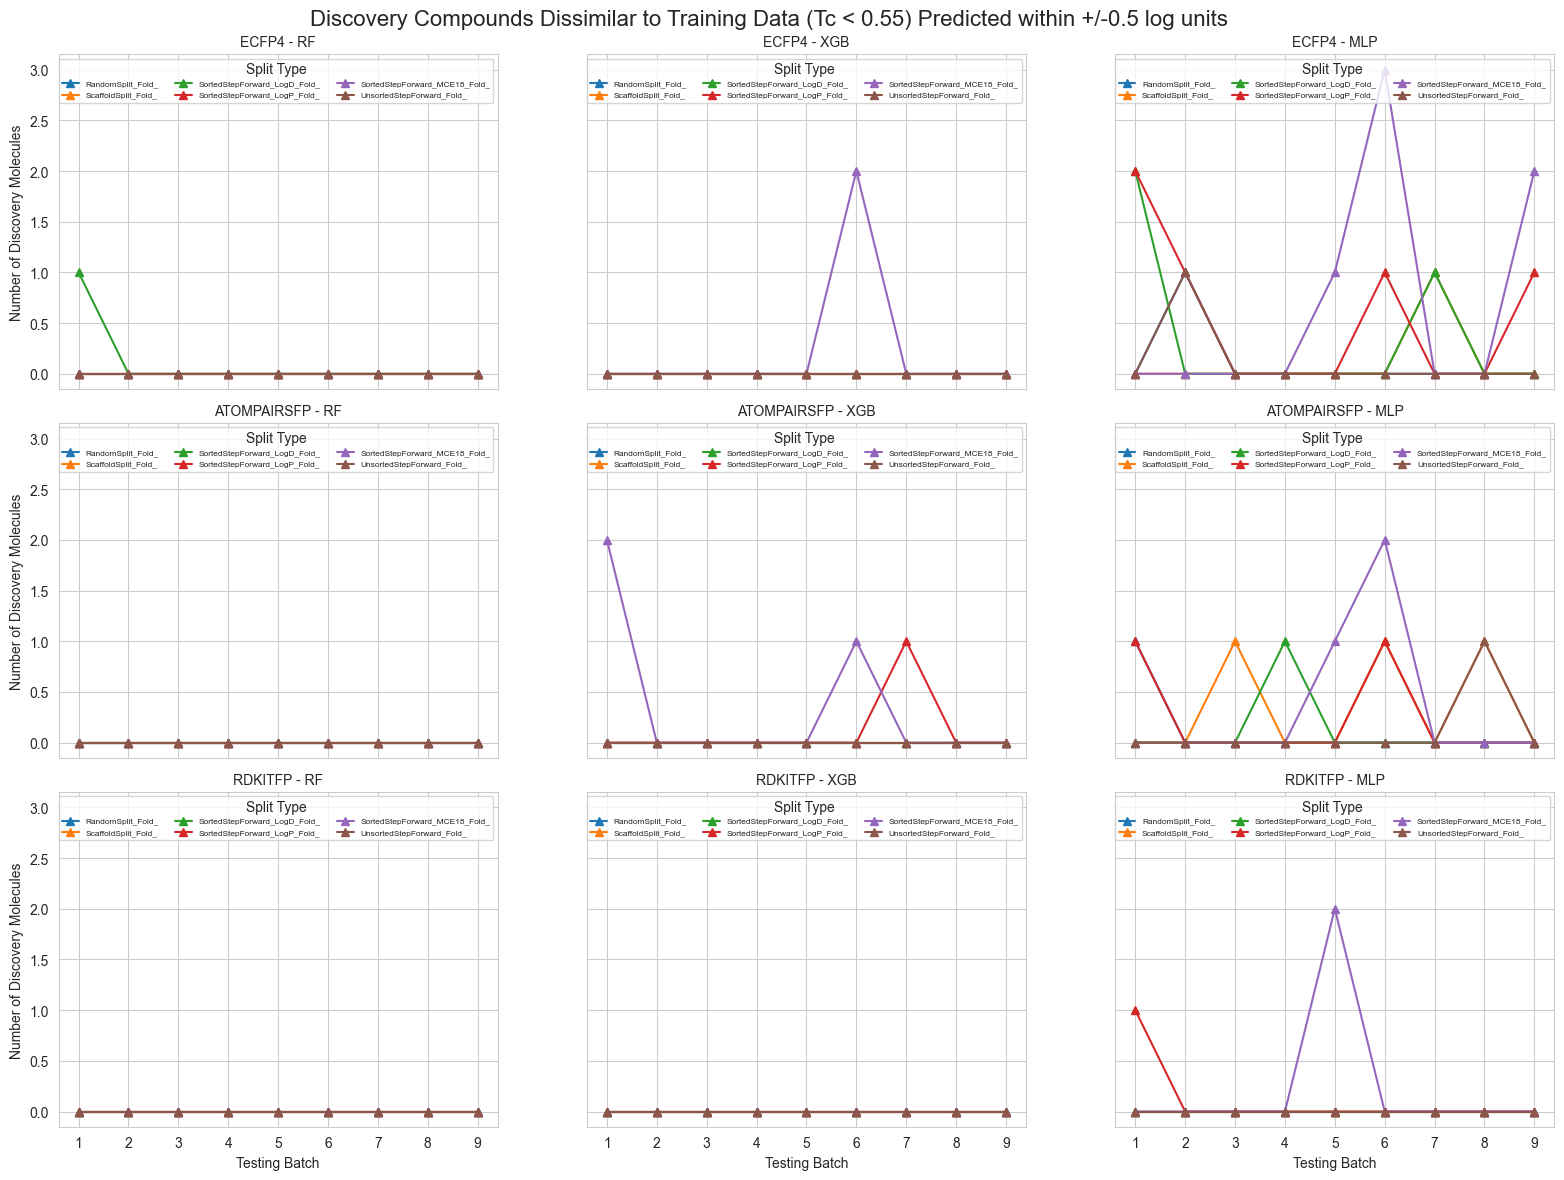

In [12]:
def plot_discovery_dissimilar_within_error_grid(
        df,
        error_range=0.5,
        condition="pchembl_value < 5.2",
        similarity_threshold=0.55,
        split_types=split_types,
        fp_cols=["ECFP4", "AtomPairsFP", "RDKitFP"],
        models=["rf", "xgb", "mlp"]
):
    fig, axes = plt.subplots(len(fp_cols), len(models), figsize=(16, 12), sharex=True, sharey=True)

    for i, fp_col in enumerate(fp_cols):
        for j, model in enumerate(models):
            ax = axes[i, j] if len(fp_cols) > 1 else axes[j]  # Handle axes for single row
            for split_prefix in split_types:
                # Identify prediction columns for the split, fingerprint, and model
                pred_cols = [col for col in df.columns if col.startswith(f"{split_prefix}") and col.endswith(
                    f"_{fp_col}_{model}_regressor_factory")]
                batch_counts = []

                for pred_col in pred_cols:
                    # Extract fold number dynamically
                    match = re.search(r"Fold_(\d+)", pred_col)
                    if not match:
                        print("WTF")
                        continue
                    fold_number = match.group(1)

                    # Construct the corresponding similarity column name
                    similarity_col = f"{split_prefix}{fold_number}_{fp_col}_Tc"

                    if similarity_col not in df.columns:
                        print(f"[Missing] !! {similarity_col} !! [Missing]")
                        continue  # Skip if the similarity column doesn't exist

                    # Filter test set compounds
                    split_col = pred_col.replace(f"_{fp_col}_{model}_regressor_factory", "")
                    test_indices = df.index[df[split_col] == "Test"]

                    # Extract true and predicted values
                    true_values = df.loc[test_indices, "pchembl_value"]
                    predicted_values = df.loc[test_indices, pred_col]

                    discovery_condition = df.loc[test_indices].eval(condition)
                    dissimilar_condition = df.loc[test_indices, similarity_col] < similarity_threshold
                    within_error_condition = abs(true_values - predicted_values) <= error_range
                    discovery_dissimilar = discovery_condition & dissimilar_condition & within_error_condition

                    # Count discovery compounds dissimilar to training data
                    within_error = discovery_dissimilar.sum()
                    batch_counts.append(within_error)

                # Add the results for this split type to the plot
                ax.plot(
                    range(1, len(batch_counts) + 1),
                    batch_counts,
                    marker='^',
                    label=f"{split_prefix}"
                )

            # Customize each subplot
            ax.set_title(f"{fp_col.upper()} - {model.upper()}", fontsize=10)
            if j == 0:
                ax.set_ylabel("Number of Discovery Molecules", fontsize=10)
            if i == len(fp_cols) - 1:
                ax.set_xlabel("Testing Batch", fontsize=10)
            ax.legend(title="Split Type", fontsize=6, ncols=3, loc="upper right")
            ax.grid(True)

    fig.suptitle(
        f"Discovery Compounds Dissimilar to Training Data (Tc < {similarity_threshold}) Predicted within +/-{error_range} log units",
        fontsize=16)
    plt.tight_layout()
    plt.show()


plot_discovery_dissimilar_within_error_grid(df, error_range=0.5, condition="pchembl_value < 5.2",
                                            similarity_threshold=0.55)

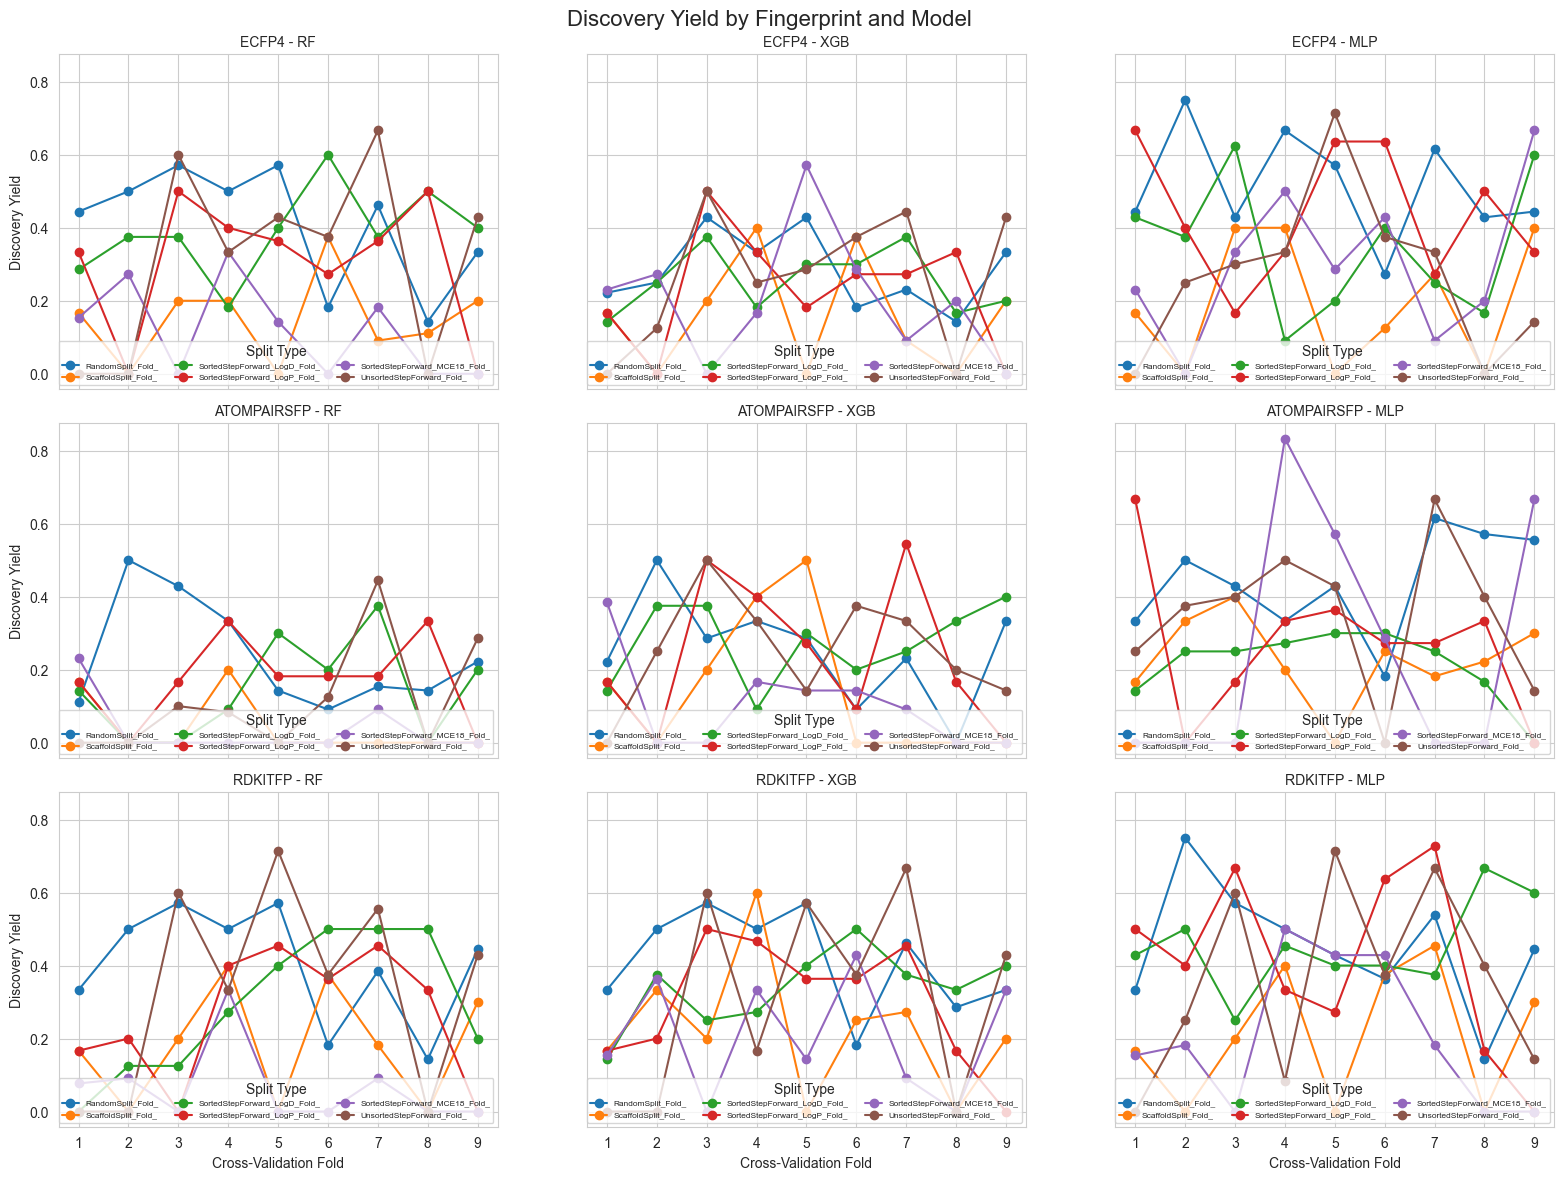

In [13]:
def plot_discovery_yield_grid(
        df,
        error_range=0.5,
        condition="pchembl_value < 5.2",
        split_types=split_types,
        fp_cols=["ECFP4", "AtomPairsFP", "RDKitFP"],
        models=["rf", "xgb", "mlp"]
):
    fig, axes = plt.subplots(len(fp_cols), len(models), figsize=(16, 12), sharex=True, sharey=True)

    for i, fp_col in enumerate(fp_cols):
        for j, model in enumerate(models):
            ax = axes[i, j] if len(fp_cols) > 1 else axes[j]  # Handle axes for a single row
            for split_prefix in split_types:
                # Identify prediction columns for the split, fingerprint, and model
                pred_cols = [col for col in df.columns if col.startswith(f"{split_prefix}") and col.endswith(
                    f"_{fp_col}_{model}_regressor_factory")]
                discovery_yields = []

                for pred_col in pred_cols:
                    # Filter test set compounds
                    split_col = pred_col.replace(f"_{fp_col}_{model}_regressor_factory", "")
                    test_indices = df.index[df[split_col] == "Test"]

                    # Extract true and predicted values
                    true_values = df.loc[test_indices, "pchembl_value"]
                    predicted_values = df.loc[test_indices, pred_col]

                    # Evaluate the discovery condition
                    discovery_condition = df.loc[test_indices].eval(condition)

                    # Check predictions within the error range
                    within_error_condition = abs(true_values - predicted_values) <= error_range
                    correctly_predicted = discovery_condition & within_error_condition

                    # Calculate Discovery Yield (fraction)
                    total_discovery = discovery_condition.sum()
                    yield_fraction = correctly_predicted.sum() / total_discovery if total_discovery > 0 else 0
                    discovery_yields.append(yield_fraction)

                # Add the results for this split type to the subplot
                ax.plot(
                    range(1, len(discovery_yields) + 1),
                    discovery_yields,
                    marker='o',
                    label=f"{split_prefix}"
                )

            # Customize each subplot
            ax.set_title(f"{fp_col.upper()} - {model.upper()}", fontsize=10)
            if j == 0:
                ax.set_ylabel("Discovery Yield", fontsize=10)
            if i == len(fp_cols) - 1:
                ax.set_xlabel("Cross-Validation Fold", fontsize=10)
            ax.legend(title="Split Type", fontsize=6, ncols=3, loc="lower right")
            ax.grid(True)

    fig.suptitle("Discovery Yield by Fingerprint and Model", fontsize=16)
    plt.tight_layout()
    plt.show()


# Example usage
plot_discovery_yield_grid(df, error_range=0.5, condition="pchembl_value < 5.2")

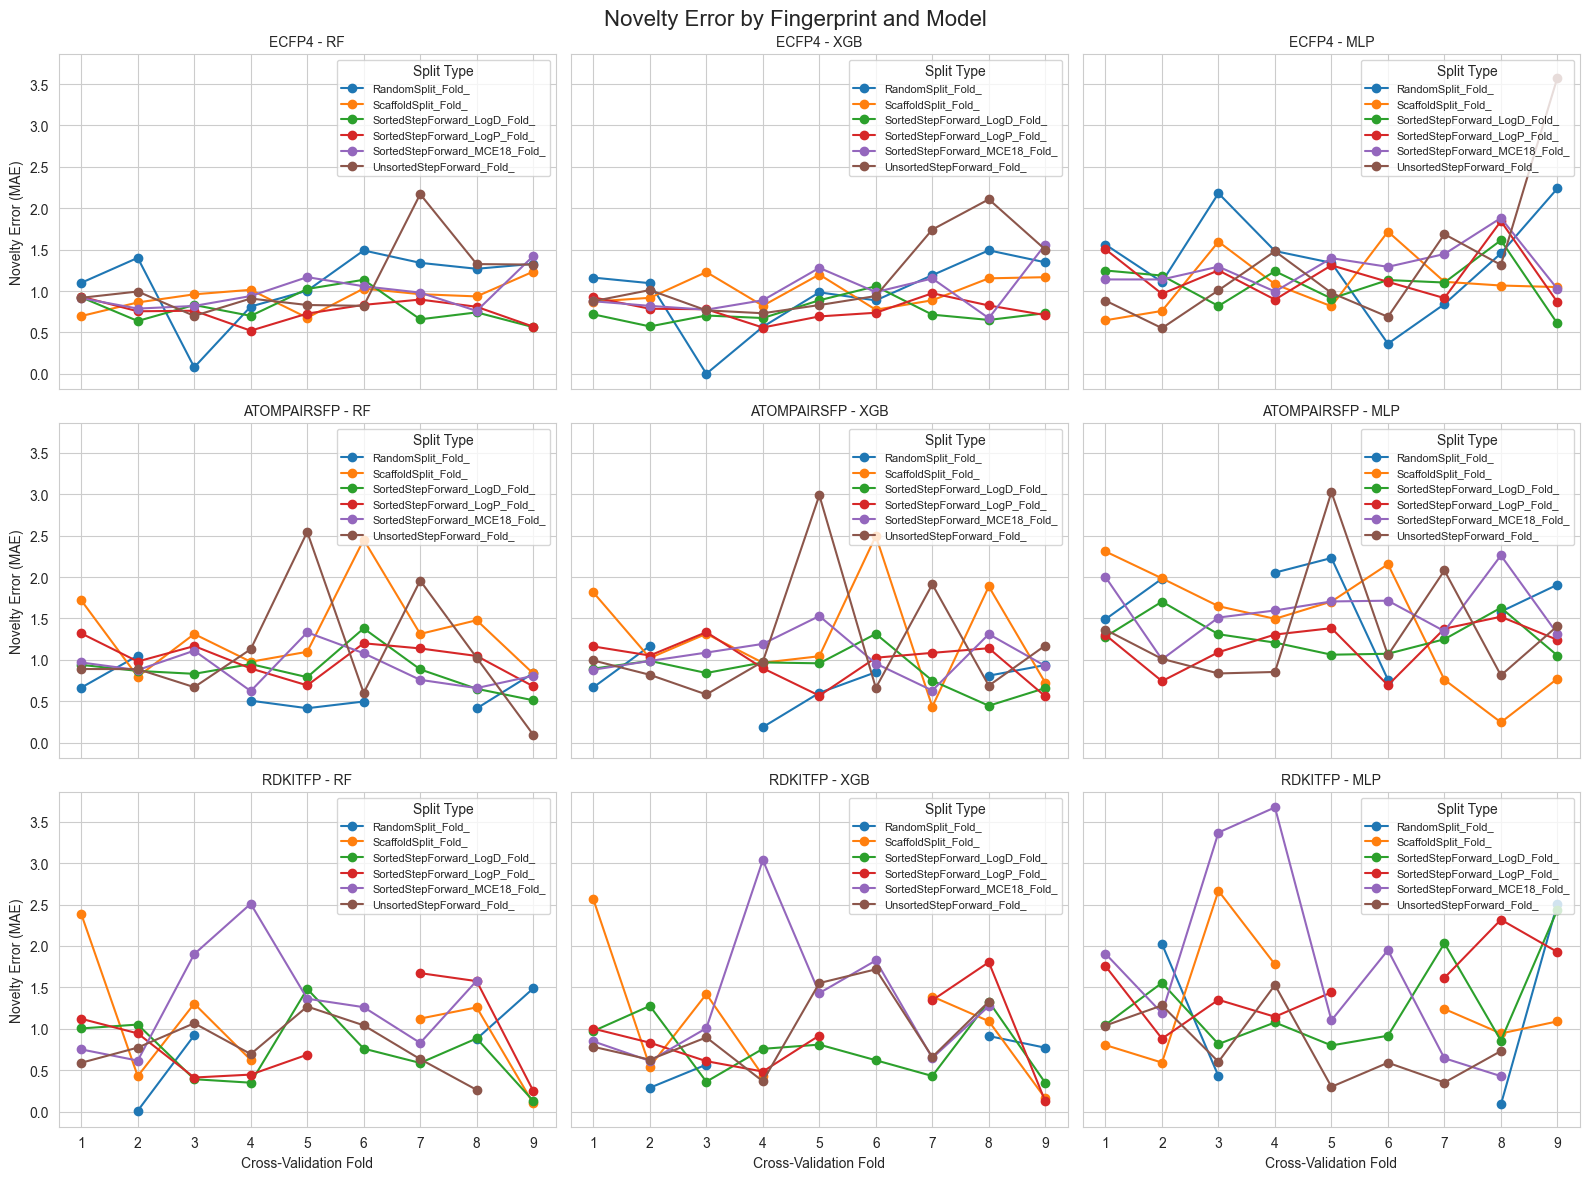

In [14]:
def plot_novelty_error_grid(
        df,
        similarity_threshold=0.55,
        split_types=split_types,
        fp_cols=["ECFP4", "AtomPairsFP", "RDKitFP"],
        models=["rf", "xgb", "mlp"]
):
    fig, axes = plt.subplots(len(fp_cols), len(models), figsize=(16, 12), sharex=True, sharey=True)

    for i, fp_col in enumerate(fp_cols):
        for j, model in enumerate(models):
            ax = axes[i, j] if len(fp_cols) > 1 else axes[j]  # Handle axes for a single row
            for split_prefix in split_types:
                # Identify prediction columns for the split, fingerprint, and model
                pred_cols = [col for col in df.columns if col.startswith(f"{split_prefix}") and col.endswith(
                    f"_{fp_col}_{model}_regressor_factory")]
                novelty_errors = []

                for pred_col in pred_cols:
                    # Extract fold number dynamically
                    match = re.search(rf"Fold_(\d+)", pred_col)
                    if not match:
                        "WTF"
                        continue
                    fold_number = match.group(1)

                    # Construct the corresponding similarity column name
                    similarity_col = f"{split_prefix}{fold_number}_{fp_col}_Tc"

                    if similarity_col not in df.columns:
                        print(similarity_col)
                        continue  # Skip if the similarity column doesn't exist

                    # Filter test set compounds
                    split_col = pred_col.replace(f"_{fp_col}_{model}_regressor_factory", "")
                    test_indices = df.index[df[split_col] == "Test"]

                    # Extract true and predicted values
                    true_values = df.loc[test_indices, "pchembl_value"]
                    predicted_values = df.loc[test_indices, pred_col]

                    # Filter dissimilar compounds (Tc < similarity_threshold)
                    dissimilar_condition = df.loc[test_indices, similarity_col] < similarity_threshold
                    dissimilar_indices = df.loc[test_indices][dissimilar_condition].index

                    # Calculate Mean Absolute Error (MAE) for dissimilar compounds
                    if len(dissimilar_indices) > 0:
                        mae = abs(true_values.loc[dissimilar_indices] - predicted_values.loc[dissimilar_indices]).mean()
                    else:
                        mae = None  # No dissimilar compounds for this fold

                    novelty_errors.append(mae)

                # Add the results for this split type to the subplot
                ax.plot(
                    range(1, len(novelty_errors) + 1),
                    novelty_errors,
                    marker='o',
                    label=f"{split_prefix}"
                )

            # Customize each subplot
            ax.set_title(f"{fp_col.upper()} - {model.upper()}", fontsize=10)
            if j == 0:
                ax.set_ylabel("Novelty Error (MAE)", fontsize=10)
            if i == len(fp_cols) - 1:
                ax.set_xlabel("Cross-Validation Fold", fontsize=10)
            ax.legend(title="Split Type", fontsize=8, loc="upper right")
            ax.grid(True)

    fig.suptitle("Novelty Error by Fingerprint and Model", fontsize=16)
    plt.tight_layout()
    plt.show()


plot_novelty_error_grid(df, similarity_threshold=0.55)

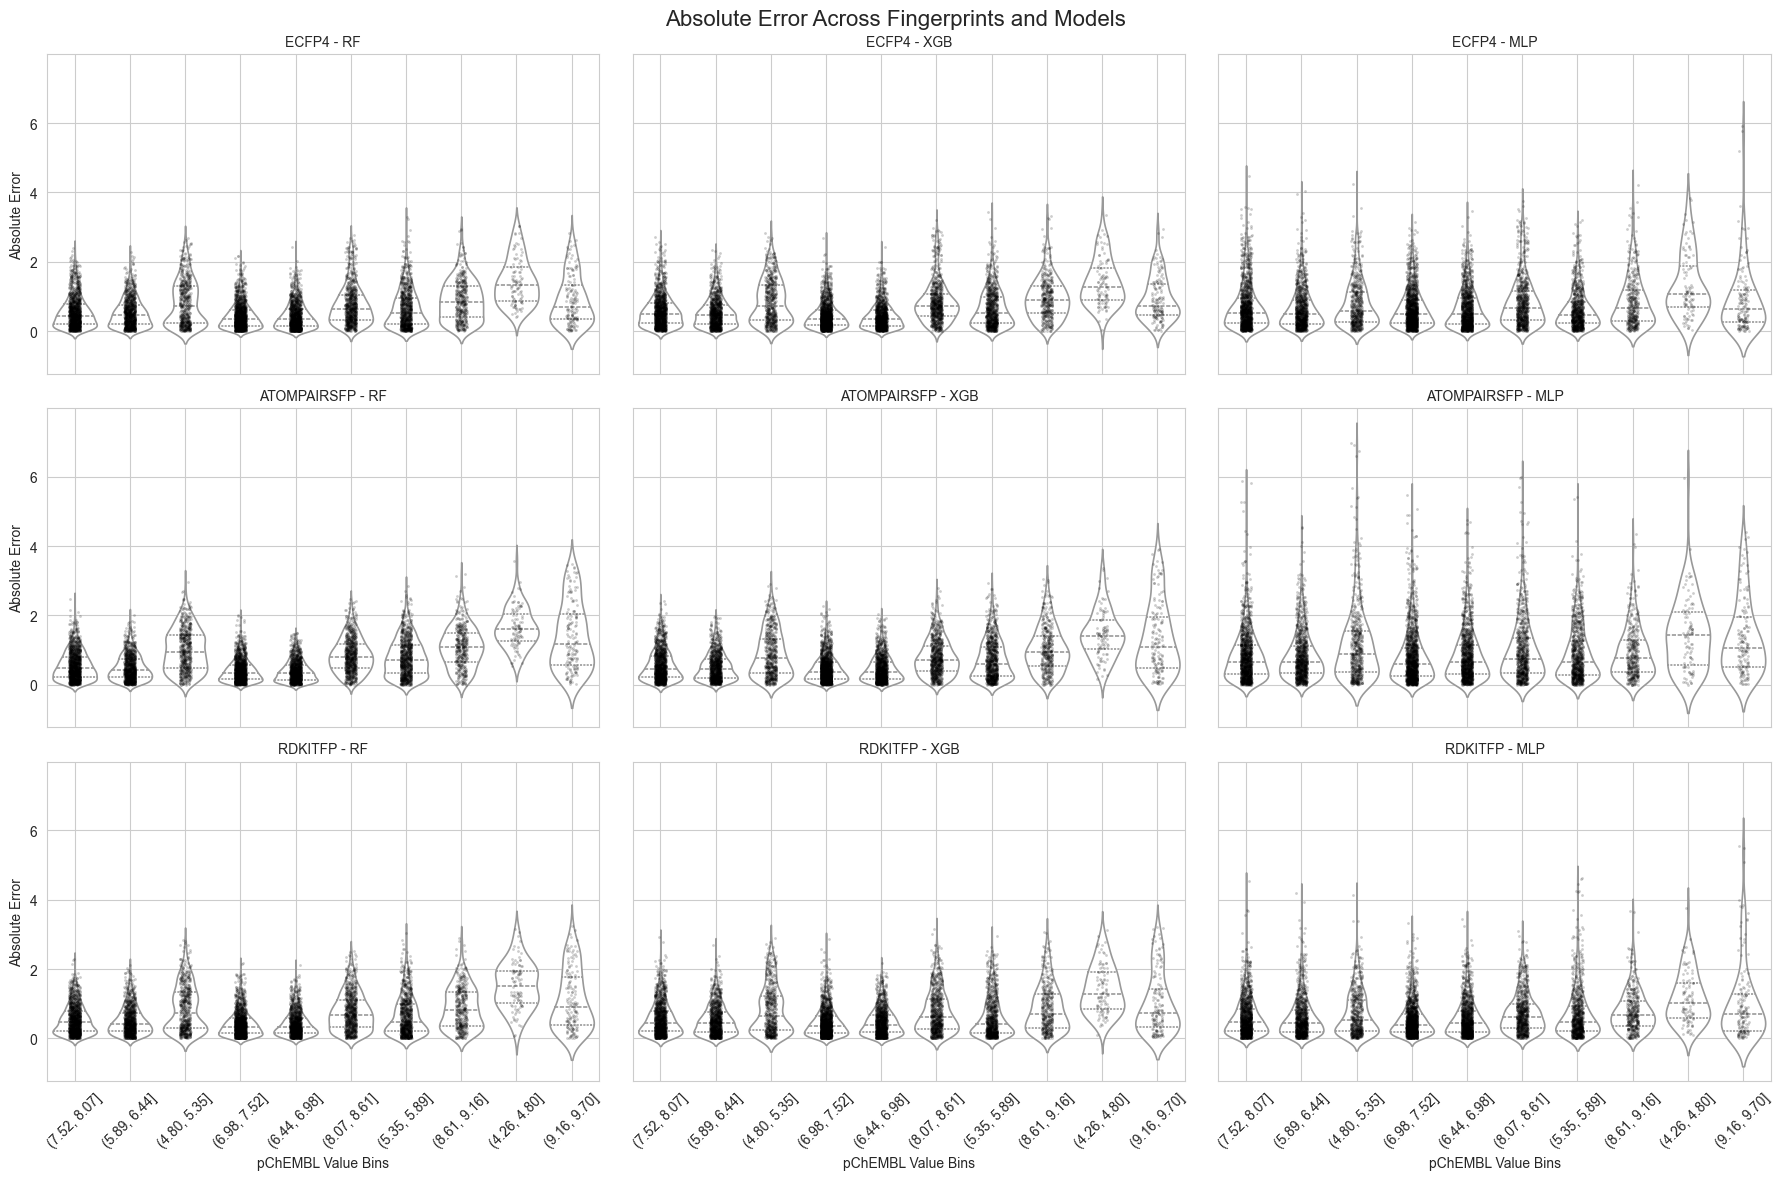

In [15]:
def plot_absolute_error_violin_grid(
        df,
        split_types=split_types,
        fp_cols=["ECFP4", "AtomPairsFP", "RDKitFP"],
        models=["rf", "xgb", "mlp"],
        bins=10
):
    num_rows = len(fp_cols)

    num_cols = len(models)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 12), sharex=True, sharey=True)
    axes = np.array(axes).reshape(num_rows, num_cols)  # Ensure correct shape

    for i, fp_col in enumerate(fp_cols):
        for j, model in enumerate(models):
            ax = axes[i, j]

            # Collect absolute errors and pchembl_values for all split types
            absolute_errors = []
            pchembl_values = []
            split_labels = []

            for split_prefix in split_types:
                pred_cols = [col for col in df.columns if col.startswith(f"{split_prefix}") and col.endswith(
                    f"_{fp_col}_{model}_regressor_factory")]

                for pred_col in pred_cols:
                    # Identify the test set based on the split column
                    split_col = pred_col.replace(f"_{fp_col}_{model}_regressor_factory", "")
                    test_indices = df.index[df[split_col] == "Test"]

                    # True and Predicted values
                    true_values = df.loc[test_indices, "pchembl_value"]
                    predicted_values = df.loc[test_indices, pred_col]

                    # Calculate absolute errors
                    abs_errors = abs(true_values - predicted_values)

                    # Store results
                    absolute_errors.extend(abs_errors)
                    pchembl_values.extend(true_values)
                    split_labels.extend([split_prefix] * len(abs_errors))

            # Bin the pchembl_values
            bins_edges = np.linspace(min(pchembl_values), max(pchembl_values), bins + 1)
            bin_indices = np.digitize(pchembl_values, bins_edges) - 1  # Adjust to 0-based indexing
            bin_indices = np.clip(bin_indices, 0, bins - 1)  # Ensure indices are within valid range
            bin_ranges = [f"({bins_edges[k]:.2f}, {bins_edges[k + 1]:.2f}]" for k in range(bins)]

            # Create a DataFrame for plotting
            plot_df = pd.DataFrame({
                "Absolute Error": absolute_errors,
                "Bin": [bin_ranges[k] for k in bin_indices]
            })

            # Plot violin plot
            sns.violinplot(
                x="Bin",
                y="Absolute Error",
                data=plot_df,
                ax=ax,
                inner="quart",
                density_norm='width',
                linewidth=1.2,
                color="white"
            )

            # Add scatter points for individual data
            sns.stripplot(
                x="Bin",
                y="Absolute Error",
                data=plot_df,
                ax=ax,
                size=2,
                color="black",
                alpha=0.2,
                jitter=0.1
            )

            # Customize the subplot
            ax.set_title(f"{fp_col.upper()} - {model.upper()}", fontsize=10)
            if j == 0:
                ax.set_ylabel("Absolute Error", fontsize=10)
            if i == len(fp_cols) - 1:
                ax.set_xlabel("pChEMBL Value Bins", fontsize=10)
            ax.tick_params(axis="x", rotation=45)
            ax.grid(True)

    # Add a suptitle and adjust layout
    fig.suptitle("Absolute Error Across Fingerprints and Models", fontsize=16)
    plt.tight_layout()
    plt.show()


# Example usage
plot_absolute_error_violin_grid(df, bins=10)